## Projet 5 OpenClassrooms : Customer segmentation of a Brazilian e-commerce site

![](olist-gente-de-verdade.jpg)

# I- Import data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
# Dislay options
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 2000)

In [2]:
# loading dataset
df_customers = pd.read_csv ('olist_customers_dataset.csv')
df_geolocation = pd.read_csv('olist_geolocation_dataset.csv')
df_order_items = pd.read_csv ('olist_order_items_dataset.csv')
df_order_payments = pd.read_csv ('olist_order_payments_dataset.csv')
df_order_reviews = pd.read_csv ('olist_order_reviews_dataset.csv')
df_orders = pd.read_csv ('olist_orders_dataset.csv')
df_products = pd.read_csv ('olist_products_dataset.csv')
df_sellers = pd.read_csv ('olist_sellers_dataset.csv')
df_categ_name_trans = pd.read_csv('product_category_name_translation.csv')

# II- Merging data

### 1- Cleaning datas

#### a- df_orders

In [3]:
# To drop useless features in df_orders
useless_column = ['order_approved_at', 'order_delivered_carrier_date', 'order_estimated_delivery_date']
df_orders.drop(columns=useless_column , axis=1, inplace=True)

# To create a list of time variables
time_vars = ['order_purchase_timestamp', 'order_delivered_customer_date']

# Convert from object to datetime
for var in time_vars : 
    df_orders[var] = pd.to_datetime(df_orders[var] , format = "%Y/%m/%d %H:%M:%S")
    
# To keep just delivered orders. for other orders, we have no "order_delivered_customer_date"
df_orders = df_orders[df_orders["order_status"] == "delivered"]

# To drop "order_status" column because all of them are delivered
df_orders.drop(labels="order_status", inplace=True, axis=1)

#### b- df_orders_items

In [4]:
# To drop Useless features in df_order_items
df_order_items.drop(columns=['seller_id','shipping_limit_date'], inplace=True)

#### c- df_orders_payment

'number of installement' could not be 0, at least it is equal to 1. However, a customer may not have freight cost.**????**

In [5]:
# To rplace 0 values of payment_installments with 1
df_order_payments['payment_installments'] = np.where(df_order_payments['payment_installments']==0, 1, 
                                                     df_order_payments['payment_installments'])

# To group payment sequential an installement
total_order_payment = pd.DataFrame (data=df_order_payments.groupby("order_id").agg({'payment_sequential':'count',
                                                                                    'payment_installments':'sum',
                                                                                    }).reset_index())
total_order_payment.rename(columns={'payment_sequential':'sequential_number','payment_installments':'installement_number'},
                           inplace=True)



#### d- df_order_reviews

In [6]:
grouped_order_review = pd.DataFrame (data=df_order_reviews.groupby(["order_id"])['review_score'].mean().reset_index())
grouped_order_review.rename({'review_score':'mean_review_score'}, axis=1, inplace=True)


### 2- Merging datas

In [7]:
#To merge all datas except sellers and geolocalisation
df = pd.merge (df_orders, df_order_items, on='order_id')
df = pd.merge (df, total_order_payment, on='order_id')
df = pd.merge (df, grouped_order_review, on='order_id')
df = pd.merge (df , df_customers, on = 'customer_id')
df

,order_id,customer_id,order_purchase_timestamp,order_delivered_customer_date,order_item_id,product_id,price,freight_value,sequential_number,installement_number,mean_review_score,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-10 21:25:13,1,87285b34884572647811a353c7ac498a,29.99,8.72,3,3,4.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-08-07 15:27:45,1,595fac2a385ac33a80bd5114aec74eb8,118.70,22.76,1,1,4.0,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-17 18:06:29,1,aa4383b373c6aca5d8797843e5594415,159.90,19.22,1,3,5.0,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-12-02 00:28:42,1,d0b61bfb1de832b15ba9d266ca96e5b0,45.00,27.20,1,1,5.0,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-16 18:17:02,1,65266b2da20d04dbe00c5c2d3bb7859e,19.90,8.72,1,1,5.0,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109362,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,2018-02-06 12:58:58,2018-02-28 17:37:56,1,f1d4ce8c6dd66c47bbaa8c6781c2a923,174.90,20.10,1,3,4.0,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP
109363,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,2017-08-27 14:46:43,2017-09-21 11:24:17,1,b80910977a37536adeddd63663f916ad,205.99,65.02,1,5,5.0,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA
109364,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:28:27,2018-01-25 23:32:54,1,d1c427060a0f73f6b889a5c7c61f2ac4,179.99,40.59,1,4,2.0,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ
109365,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:28:27,2018-01-25 23:32:54,2,d1c427060a0f73f6b889a5c7c61f2ac4,179.99,40.59,1,4,2.0,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ


<AxesSubplot:>

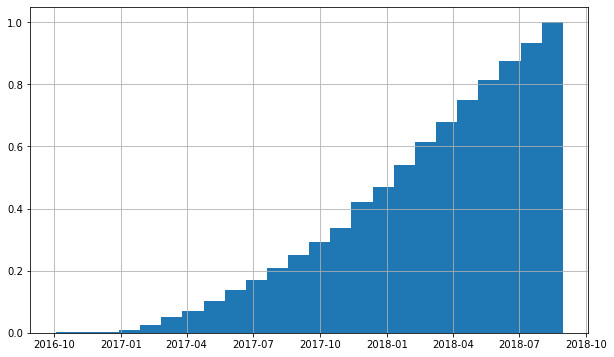

In [8]:
plt.figure(figsize=(10,6))
df['order_purchase_timestamp'].hist(bins=24, cumulative=True, density=True)

# III- Create train dataframe

In [9]:
min_date = df["order_purchase_timestamp"].min()
print(min_date)
max_date = df["order_purchase_timestamp"].max()
print(max_date)
delta_time = round((max_date - min_date)/np.timedelta64(1,'M'))
delta_time

2016-10-03 09:44:50
2018-08-29 15:00:37


23

In [10]:
# The period of train data is 15 months
train_period = 6
train_df = df [df['order_purchase_timestamp']<(min_date+pd.DateOffset(months=train_period))]
max_date_train = train_df["order_purchase_timestamp"].max()
max_date_train

Timestamp('2017-04-03 09:14:02')

In [11]:
def create_train_df(months):
  
    train_df = df [df['order_purchase_timestamp']<(min_date+pd.DateOffset(months=months))]
   
    #To calculate Total features
    total_df = pd.DataFrame(data = train_df.groupby(['customer_unique_id'])\
                                 .agg({'order_id':'nunique',                                       
                                       'price':'sum'})\
                                 .reset_index())
    total_df.rename({'order_id':'total_orders',
                 'price':'total_products_payment',}, inplace=True, axis=1)
    total_df.sort_values(by='total_orders', ascending=False)
    train_df['delivery_delay(day)']= (train_df['order_delivered_customer_date'] - train_df['order_purchase_timestamp']).dt.round('1d').dt.days
    mean_df = pd.DataFrame(data = train_df.groupby(['customer_unique_id']).agg({'mean_review_score':'mean',
                                                                                'delivery_delay(day)':'mean'}).reset_index())
    
    
   
    #To calculate delivery delay for each order
    train_df['delivery_delay(day)']= (train_df['order_delivered_customer_date'] - train_df['order_purchase_timestamp'])\
                           .dt.round('1d').dt.days
    
    #Recency
    recency = train_df.groupby('customer_unique_id').agg({'order_purchase_timestamp':['min','max']}).reset_index()
    recency.columns = recency.columns.droplevel(0)
    recency.rename({'min':'first_purchase_date',
                'max':'last_purchase_date',
                '':'customer_unique_id'}, 
              axis=1, inplace=True)
    
    max_date_train = train_df["order_purchase_timestamp"].max()
    recency['recency(day)'] = (max_date_train - recency['last_purchase_date']).dt.round('1d').dt.days
    recency.sort_values(by='recency(day)')
    
    #To merge total mean and recendy data
    train_df = pd.merge (total_df, recency, on='customer_unique_id')
    train_df = pd.merge (train_df, mean_df, on='customer_unique_id')

    train_df.drop(columns=['first_purchase_date','last_purchase_date'], axis=1, inplace=True)
    train_df = train_df.set_index('customer_unique_id')
    train_df.rename(columns={'total_orders':'Frequency', 'total_products_payment':'Monetary'}, inplace=True)
    train_df.dropna(inplace=True)
    return train_df


In [12]:
train_df = create_train_df(train_period)
train_df

,Frequency,Monetary,recency(day),mean_review_score,delivery_delay(day)
customer_unique_id,,,,,
0000f46a3911fa3c0805444483337064,1,69.00,24,3.0,26.0
0005e1862207bf6ccc02e4228effd9a0,1,135.00,29,4.0,4.0
00115fc7123b5310cf6d3a3aa932699e,1,59.99,71,4.0,11.0
001f3c4211216384d5fe59b041ce1461,1,24.88,15,3.0,11.0
002043098f10ba39a4600b6c52fbfe3c,1,176.99,8,4.0,24.0
...,...,...,...,...,...
ffe2dd1f3b0cbf0b5f35e818ec03c49b,1,89.99,28,4.0,13.0
ffe3e199b9d0b7fb7d2d29a5b9498447,1,146.90,19,1.0,21.0
ffebb6424578e7bb153322da9d65634f,1,629.00,77,1.0,38.0


# IV- Create train dataframe

In [13]:
def create_dataframe(days):
   
    period_df = df [df['order_purchase_timestamp']<(max_date_train+pd.DateOffset(days))]
   
    #To calculate Total features
    total_df = pd.DataFrame(data = period_df.groupby(['customer_unique_id'])\
                                 .agg({'order_id':'nunique',                                       
                                       'price':'sum'})\
                                 .reset_index())
    total_df.rename({'order_id':'total_orders',
                 'price':'total_products_payment',}, inplace=True, axis=1)
    total_df.sort_values(by='total_orders', ascending=False)
    period_df['delivery_delay(day)']= (period_df['order_delivered_customer_date'] - period_df['order_purchase_timestamp']).dt.round('1d').dt.days
    mean_df = pd.DataFrame(data = period_df.groupby(['customer_unique_id']).agg({'mean_review_score':'mean',
                                                                                'delivery_delay(day)':'mean'}).reset_index())
    
    
   
    #To calculate delivery delay for each order
    period_df['delivery_delay(day)']= (period_df['order_delivered_customer_date'] - period_df['order_purchase_timestamp'])\
                           .dt.round('1d').dt.days
    
    #Recency
    recency = period_df.groupby('customer_unique_id').agg({'order_purchase_timestamp':['min','max']}).reset_index()
    recency.columns = recency.columns.droplevel(0)
    recency.rename({'min':'first_purchase_date',
                'max':'last_purchase_date',
                '':'customer_unique_id'}, 
              axis=1, inplace=True)
    
    max_date_period = period_df["order_purchase_timestamp"].max()
    recency['recency(day)'] = (max_date_period - recency['last_purchase_date']).dt.round('1d').dt.days
    recency.sort_values(by='recency(day)')
    
    #To merge total mean and recendy data
    period_df = pd.merge (total_df, recency, on='customer_unique_id')
    period_df = pd.merge (period_df, mean_df, on='customer_unique_id')

    period_df.drop(columns=['first_purchase_date','last_purchase_date'], axis=1, inplace=True)
    period_df = period_df.set_index('customer_unique_id')
    period_df = period_df[period_df.index.isin(train_df.index)]

    period_df.rename(columns={'total_orders':'Frequency', 'total_products_payment':'Monetary'}, inplace=True)
    period_df.dropna(inplace=True)
    return period_df


# V- Compare train and periodic data with ARI score

In [14]:
scale0 = StandardScaler()
scale0.fit(train_df)
train_df_scale = scale0.transform(train_df)
model0 = KMeans(n_clusters=3, random_state=1)

In [15]:
train_labels = model0.fit_predict(train_df_scale)

In [16]:
train_df_scale.shape

(5204, 5)

In [20]:
ari_score = []
#The period of test data is the period of train data + 15 days*n
n_days = (delta_time-train_period)*30
for p in np.arange(15,n_days,15):
    # Create dataset for period
    period_df = create_dataframe(p)
    
    # Implementing model
    period_df_scale = StandardScaler().fit_transform(period_df)
    model = KMeans(n_clusters=3, random_state=1)
    p_labels0 = model0.predict(scale0.transform(period_df))    
    p_labels = model.fit_predict(period_df_scale)
    
    # Calculate ARI score
    ari_p = metrics.adjusted_rand_score(p_labels0, p_labels)
    ari_score.append([p,ari_p])
    
ari_score = pd.DataFrame(ari_score, columns=["periode(days)", "ARI"])    
ari_score

,periode(days),ARI
0,30,0.978876
1,60,0.967863
2,90,0.954804
3,120,0.932097
4,150,0.904632
5,180,0.863092
6,210,0.816052
7,240,0.760996
8,270,0.684064
9,300,0.594766


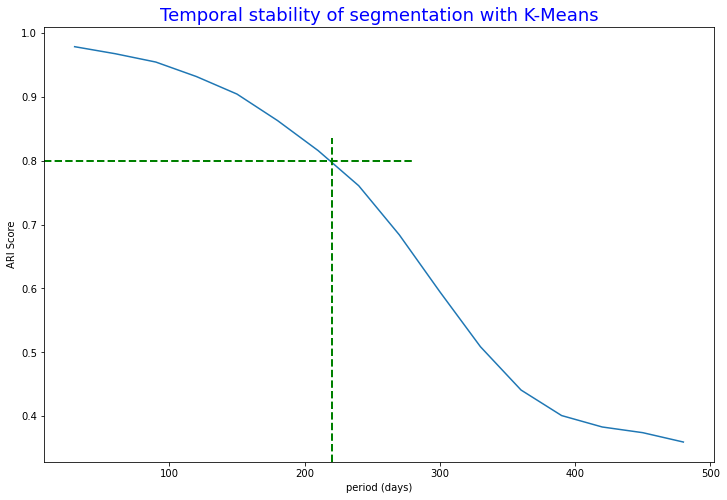

In [31]:
# plot ARI Score
fig = plt.figure(figsize=(12,8))
plt
sns.lineplot(data=ari_score, x="periode(days)", y="ARI")

plt.xlabel("period (days)")
plt.ylabel("ARI Score")
plt.title("Temporal stability of segmentation with K-Means",
          fontsize=18,
          color="b")
plt.axhline(y=0.8, linestyle="--", color="green", xmax=0.55, linewidth=2)
plt.axvline(x=220, linestyle="--", color="green", ymax=1.7-(ari_score.iloc[2][1]), linewidth=2)
plt.show()